### Packages

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt

### Cournot

Dynamic Demand:
- $p_t = u_t - v \sum_i q_{it} + x_t$ 
- $x_t = \rho x_{t-1} + e_t, e_t \sim N(0,\sigma)$

Walrasian 
- $\pi_w = \max_{q_i}{(p - w) q_i}$ 
- $w = u - v Q$
- $Q_w = \frac{u-w}{v}$
- $P_w = w$
- $q_w \in [0,Q_w], \pi_w = 0, \Pi_w = 0$

Nash
- $\pi_c = \max_{q_i}{(p(Q) - w) q_i}$ 
- $p(Q) - w - v q_i = 0$
- $n p(Q) = n w + v Q = n u - n v Q$
- $Q_c = \frac{n(u-w)}{v(n+1)}$
- $P_c = u - v Q$
- $q_c = Q_c/n$

Monopoly
- $\pi_m = \max_{Q}{(p(Q) - w) Q}$ 
- $p(Q)=w+vQ=u-vQ$ 
- $Q_m =\frac{u-w}{2v}$ 
- $P_m =\frac{u-w}{2v}$


In [9]:
# parameters of model
gamma = 0.99
u = 40
v = 1
w = 4
n = 2
sigma = 0.4
rho = 0.95

In [10]:
def price(Q,u,v):
    return u-v*Q

def profit(P,Q):
    return

class cournot:
    def __init__(self,u,v,w,n):
        self.u=u
        self.v=v
        self.w=w
        self.n=n
        self.Qw=(u-w)/v
        self.Qc=n*(u-w)/v/(n+1)
        self.Qm=(u-w)/2*v
        self.Pw = price(self.Qw,u,v)
        self.Pc = price(self.Qc,u,v)
        self.Pm = price(self.Qm,u,v)
        self.Πw = 0
        self.Πc = (self.Pc-w)*self.Qc
        self.Πm = (self.Pm-w)*self.Qm
        self.qw = self.Qw/n
        self.qc = self.Qc/n
        self.qm = self.Qm/n
        self.πw = 0
        self.πc = self.Πc/n
        self.πm = self.Πm/n
    
    def price(self,q,q_):
        return self.u-v*(q+q_)
    
    def profit(self,q,q_):
        return (self.price(q,q_)-w)*q
        
game1 = cournot(40,1,4,2)

In [11]:
game1.Qc, game1.qc, game1.Pc, game1.w, game1.Πc, game1.profit(12,12)

(24.0, 12.0, 16.0, 4, 288.0, 144)

In [12]:
game1.Qm, game1.qm, game1.Pm, game1.w, game1.Πm, game1.profit(9,9)

(18.0, 9.0, 22.0, 4, 324.0, 162)

### Shocks

In [13]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
def whichidx(value, array):
    return np.argmin(np.abs(array-value))

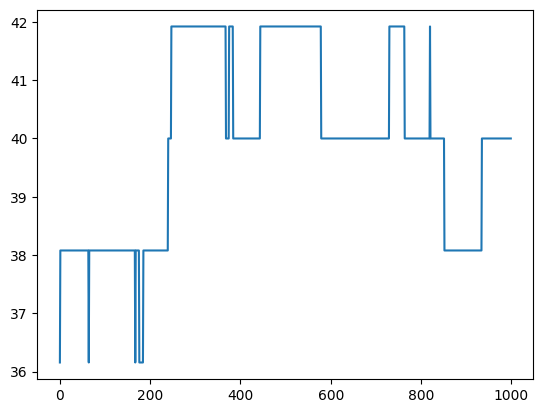

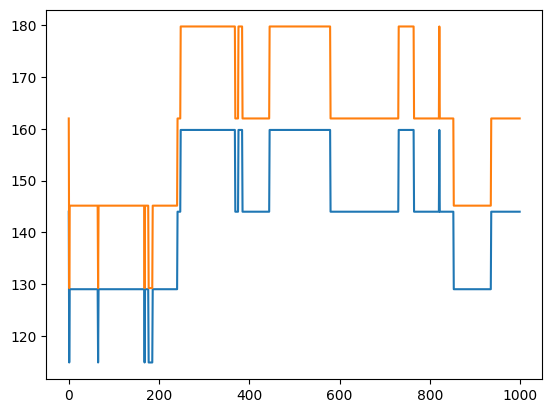

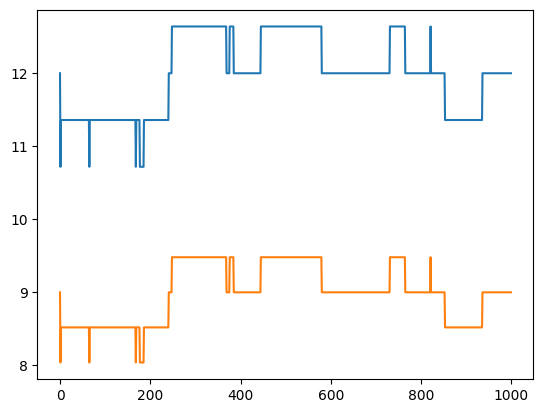

In [14]:
import numpy as np
e = np.random.normal(1)*sigma
K = 5
Z, α, F, P = tauchen(rho, sigma, K, m=3)
u_history=[]
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

uidx = 0
for t in range(1000):
    # find competition level profit 
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).πc)
    pm_history.append(cournot(u,v,w,n).πm)
   
    # generate next shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    u_history.append(u)
    
plt.plot(u_history)
plt.show()

plt.plot(pc_history)
plt.plot(pm_history)
plt.show()

plt.plot(qc_history)
plt.plot(qm_history)
plt.show()

### Q-Learning

In [15]:
import random
import numpy as np

# define the Boltzmann action selection function
def boltzmann_action_selection(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    action = np.random.choice(range(len(probs)), p=probs)
    return action

# initialize the state
state1 = 0
state2 = 0
u = 40
uidx = 0

# initialize the Q-table
game = game1
num_states1 = 50
num_states2 = 10
num_actions = 50
Z, α, F, P = tauchen(rho, sigma, num_states2, m=3)
uidx = int(round(num_states2/2))

Q1 = np.random.uniform(cournot(u,v,w,n).πc,cournot(u,v,w,n).πm,(num_states1, num_states2, num_actions))
Q2 = np.random.uniform(cournot(u,v,w,n).πc,cournot(u,v,w,n).πm,(num_states1, num_states2, num_actions))

# histories
q1_history = []
q2_history = []
u_history = []
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

action2quantity = np.linspace(8,13,num_actions)
action2quantity


array([ 8.  ,  8.1 ,  8.2 ,  8.31,  8.41,  8.51,  8.61,  8.71,  8.82,
        8.92,  9.02,  9.12,  9.22,  9.33,  9.43,  9.53,  9.63,  9.73,
        9.84,  9.94, 10.04, 10.14, 10.24, 10.35, 10.45, 10.55, 10.65,
       10.76, 10.86, 10.96, 11.06, 11.16, 11.27, 11.37, 11.47, 11.57,
       11.67, 11.78, 11.88, 11.98, 12.08, 12.18, 12.29, 12.39, 12.49,
       12.59, 12.69, 12.8 , 12.9 , 13.  ])

In [18]:
# initialize Boltzmann Q-learning parameters
alpha = 0.1
initial_temperature = 1.0
temperature_decay = 0.999995
min_temperature = 0.001
temperature = initial_temperature
initial_eps = 1.0
eps_decay = 0.999995
min_eps = 0.001
eps = initial_eps
errors = []

In [30]:
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 1000000
for episode in range(num_episodes):
    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action1 = boltzmann_action_selection(Q1, state1, uidx, temperature)
    else:
        action1 = np.random.choice(range(num_actions))

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action2 = boltzmann_action_selection(Q2, state2, uidx, temperature)
    else:
        action2 = np.random.choice(range(num_actions))

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

    # update the Q-value for the selected action in the current state
    Q1[state1][uidx][action1] =  (1-alpha)*Q1[state1][uidx][action1] + alpha * (reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx])))
    Q2[state2][uidx][action2] =  (1-alpha)*Q2[state2][uidx][action2] + alpha * (reward2 + gamma * np.max(np.average(Q2[next_state2],axis=0,weights=P[uidx])))
    
   # generate shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    # update temperature
    temperature = max(min_temperature, temperature * temperature_decay)
    eps = max(min_eps, eps * eps_decay)
    error = reward1 + gamma * np.max(Q1[next_state1][uidx])-Q1[state1][uidx][action1] 
    errors.append(error)
    if num_episodes>1000:
        print(f'{episode},{np.mean(errors[-1000:]):0.2f},{uidx:0.2f}, {action1:0.2f}, {action2:0.2f}, {reward1:0.2f}, {reward2:0.2f}, {temperature:0.2f}, {eps:0.2f}')
    
    u_history.append(u)
    q1_history.append(quantity1)
    q2_history.append(quantity2)
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
    pm_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
  

0,514.10,0.00, 23.00, 40.00, 140.42, 163.97, 0.00, 0.01
1,514.39,1.00, 21.00, 40.00, 100.74, 120.00, 0.00, 0.01
2,514.12,0.00, 36.00, 5.00, 149.74, 109.16, 0.00, 0.01
3,514.23,1.00, 30.00, 30.00, 110.99, 110.99, 0.00, 0.01
4,514.28,2.00, 26.00, 1.00, 151.87, 115.50, 0.00, 0.01
5,514.34,2.00, 48.00, 30.00, 127.76, 109.57, 0.00, 0.01
6,514.59,3.00, 11.00, 23.00, 131.32, 148.95, 0.00, 0.01
7,514.05,3.00, 13.00, 48.00, 116.53, 161.15, 0.00, 0.01
8,513.85,3.00, 40.00, 30.00, 139.86, 128.05, 0.00, 0.01
9,513.74,3.00, 37.00, 48.00, 118.29, 129.57, 0.00, 0.01
10,513.62,3.00, 40.00, 17.00, 155.89, 125.60, 0.00, 0.01
11,513.17,3.00, 26.00, 48.00, 118.97, 144.04, 0.00, 0.01
12,513.09,3.00, 40.00, 8.00, 166.98, 121.85, 0.00, 0.01
13,513.32,3.00, 34.00, 48.00, 118.73, 133.51, 0.00, 0.01
14,513.07,3.00, 40.00, 25.00, 146.02, 127.52, 0.00, 0.01
15,513.08,4.00, 34.00, 48.00, 118.73, 133.51, 0.00, 0.01
16,513.02,4.00, 8.00, 39.00, 130.28, 177.02, 0.00, 0.01
17,512.85,4.00, 37.00, 46.00, 130.75, 140.95,

374,512.37,6.00, 35.00, 1.00, 203.74, 142.66, 0.00, 0.01
375,512.31,6.00, 3.00, 31.00, 147.95, 198.84, 0.00, 0.01
376,512.61,7.00, 41.00, 16.00, 188.42, 148.97, 0.00, 0.01
377,512.61,7.00, 39.00, 39.00, 169.82, 169.82, 0.00, 0.01
378,512.31,6.00, 19.00, 32.00, 168.27, 190.73, 0.00, 0.01
379,512.39,6.00, 22.00, 31.00, 162.62, 177.19, 0.00, 0.01
380,512.44,6.00, 41.00, 19.00, 184.69, 150.66, 0.00, 0.01
381,512.07,5.00, 30.00, 39.00, 157.51, 170.59, 0.00, 0.01
382,511.27,5.00, 45.00, 48.00, 137.72, 141.07, 0.00, 0.01
383,511.17,6.00, 42.00, 34.00, 155.68, 145.34, 0.00, 0.01
384,510.79,6.00, 28.00, 36.00, 160.15, 172.19, 0.00, 0.01
385,510.68,6.00, 15.00, 20.00, 168.78, 177.82, 0.00, 0.01
386,510.61,6.00, 46.00, 14.00, 192.42, 142.92, 0.00, 0.01
387,510.79,5.00, 41.00, 28.00, 173.50, 154.61, 0.00, 0.01
388,510.58,6.00, 21.00, 44.00, 139.91, 172.29, 0.00, 0.01
389,510.54,5.00, 38.00, 35.00, 164.29, 160.06, 0.00, 0.01
390,510.70,6.00, 46.00, 49.00, 136.25, 139.53, 0.00, 0.01
391,511.03,6.00,

618,507.86,5.00, 18.00, 49.00, 125.28, 165.57, 0.00, 0.01
619,507.95,5.00, 25.00, 35.00, 150.93, 165.52, 0.00, 0.01
620,507.83,6.00, 46.00, 33.00, 156.97, 140.57, 0.00, 0.01
621,507.86,6.00, 9.00, 28.00, 156.12, 190.06, 0.00, 0.01
622,507.69,6.00, 30.00, 17.00, 182.35, 160.48, 0.00, 0.01
623,507.45,6.00, 23.00, 1.00, 194.85, 152.58, 0.00, 0.01
624,507.11,6.00, 3.00, 49.00, 132.69, 207.67, 0.00, 0.01
625,506.75,6.00, 35.00, 16.00, 186.03, 154.86, 0.00, 0.01
626,506.84,5.00, 6.00, 31.00, 150.76, 195.42, 0.00, 0.01
627,507.21,5.00, 10.00, 41.00, 137.32, 185.47, 0.00, 0.01
628,507.38,5.00, 26.00, 37.00, 149.13, 164.84, 0.00, 0.01
629,507.06,5.00, 30.00, 11.00, 179.67, 148.18, 0.00, 0.01
630,506.67,4.00, 25.00, 48.00, 136.93, 167.39, 0.00, 0.01
631,506.41,4.00, 8.00, 48.00, 122.18, 178.75, 0.00, 0.01
632,506.16,4.00, 8.00, 46.00, 123.98, 178.51, 0.00, 0.01
633,505.55,4.00, 46.00, 46.00, 129.29, 129.29, 0.00, 0.01
634,505.68,5.00, 46.00, 37.00, 140.95, 130.75, 0.00, 0.01
635,505.96,5.00, 30.

982,507.19,2.00, 0.00, 24.00, 123.33, 161.08, 0.00, 0.01
983,507.43,3.00, 38.00, 24.00, 137.05, 120.56, 0.00, 0.01
984,507.59,4.00, 33.00, 21.00, 150.15, 133.97, 0.00, 0.01
985,507.18,4.00, 24.00, 44.00, 132.01, 157.80, 0.00, 0.01
986,506.99,4.00, 4.00, 42.00, 125.11, 182.80, 0.00, 0.01
987,507.09,4.00, 42.00, 11.00, 174.03, 129.22, 0.00, 0.01
988,506.90,4.00, 25.00, 8.00, 170.99, 142.87, 0.00, 0.01
989,506.54,3.00, 29.00, 48.00, 128.40, 151.11, 0.00, 0.01
990,506.29,3.00, 40.00, 44.00, 122.60, 126.74, 0.00, 0.01
991,506.34,4.00, 45.00, 48.00, 116.21, 119.04, 0.00, 0.01
992,506.42,4.00, 8.00, 16.00, 150.97, 164.95, 0.00, 0.01
993,505.98,4.00, 18.00, 46.00, 128.29, 165.56, 0.00, 0.01
994,505.99,5.00, 46.00, 38.00, 139.65, 130.67, 0.00, 0.01
995,506.25,5.00, 32.00, 12.00, 179.54, 147.01, 0.00, 0.01
996,506.17,5.00, 44.00, 32.00, 158.27, 142.75, 0.00, 0.01
997,505.91,5.00, 10.00, 46.00, 132.71, 186.76, 0.00, 0.01
998,506.05,5.00, 5.00, 37.00, 137.37, 190.07, 0.00, 0.01
999,505.91,5.00, 30

1333,501.43,7.00, 41.00, 39.00, 170.23, 167.38, 0.00, 0.01
1334,501.18,7.00, 19.00, 39.00, 161.17, 194.27, 0.00, 0.01
1335,501.58,7.00, 19.00, 23.00, 177.40, 184.69, 0.00, 0.01
1336,501.53,7.00, 20.00, 23.00, 178.20, 183.63, 0.00, 0.01
1337,501.76,6.00, 20.00, 44.00, 156.68, 194.90, 0.00, 0.01
1338,501.23,5.00, 38.00, 33.00, 166.71, 159.55, 0.00, 0.01
1339,501.36,5.00, 28.00, 49.00, 136.47, 163.41, 0.00, 0.01
1340,501.26,6.00, 25.00, 39.00, 146.62, 166.47, 0.00, 0.01
1341,501.32,6.00, 30.00, 27.00, 171.06, 166.32, 0.00, 0.01
1342,500.97,6.00, 48.00, 1.00, 209.99, 131.91, 0.00, 0.01
1343,500.71,6.00, 3.00, 49.00, 132.69, 207.67, 0.00, 0.01
1344,500.58,6.00, 35.00, 16.00, 186.03, 154.86, 0.00, 0.01
1345,500.54,6.00, 6.00, 31.00, 150.76, 195.42, 0.00, 0.01
1346,500.45,6.00, 41.00, 35.00, 164.80, 156.51, 0.00, 0.01
1347,500.23,6.00, 2.00, 39.00, 140.27, 204.82, 0.00, 0.01
1348,500.18,6.00, 30.00, 49.00, 146.23, 171.86, 0.00, 0.01
1349,500.33,6.00, 35.00, 1.00, 203.74, 142.66, 0.00, 0.01
13

1576,501.22,4.00, 33.00, 42.00, 135.50, 146.44, 0.00, 0.01
1577,500.93,3.00, 42.00, 44.00, 132.65, 134.86, 0.00, 0.01
1578,500.81,3.00, 45.00, 43.00, 122.64, 120.65, 0.00, 0.01
1579,500.66,3.00, 35.00, 10.00, 163.47, 127.43, 0.00, 0.01
1580,500.89,2.00, 47.00, 2.00, 175.55, 112.55, 0.00, 0.01
1581,500.67,2.00, 35.00, 7.00, 157.13, 118.33, 0.00, 0.01
1582,500.63,3.00, 43.00, 32.00, 126.50, 115.04, 0.00, 0.01
1583,500.46,4.00, 36.00, 47.00, 119.65, 131.15, 0.00, 0.01
1584,500.22,5.00, 48.00, 24.00, 157.69, 127.75, 0.00, 0.01
1585,499.89,4.00, 12.00, 33.00, 146.07, 180.00, 0.00, 0.01
1586,499.79,5.00, 38.00, 34.00, 145.22, 140.23, 0.00, 0.01
1587,499.78,5.00, 9.00, 49.00, 129.39, 188.61, 0.00, 0.01
1588,499.95,5.00, 25.00, 20.00, 167.08, 159.00, 0.00, 0.01
1589,499.66,5.00, 28.00, 33.00, 154.20, 161.44, 0.00, 0.01
1590,499.25,5.00, 28.00, 39.00, 147.55, 162.81, 0.00, 0.01
1591,499.21,6.00, 45.00, 39.00, 149.28, 142.03, 0.00, 0.01
1592,499.58,6.00, 30.00, 42.00, 154.13, 171.19, 0.00, 0.01


1783,497.72,3.00, 36.00, 43.00, 124.41, 132.03, 0.00, 0.01
1784,497.50,3.00, 35.00, 36.00, 132.77, 133.94, 0.00, 0.01
1785,497.64,3.00, 44.00, 2.00, 175.17, 115.06, 0.00, 0.01
1786,497.84,3.00, 24.00, 39.00, 128.42, 147.23, 0.00, 0.01
1787,498.01,3.00, 32.00, 15.00, 156.85, 132.70, 0.00, 0.01
1788,498.16,3.00, 31.00, 20.00, 150.87, 135.70, 0.00, 0.01
1789,498.59,3.00, 39.00, 49.00, 116.67, 126.61, 0.00, 0.01
1790,498.94,3.00, 47.00, 45.00, 119.40, 117.50, 0.00, 0.01
1791,499.03,2.00, 0.00, 36.00, 120.36, 175.63, 0.00, 0.01
1792,499.04,3.00, 43.00, 24.00, 136.61, 115.23, 0.00, 0.01
1793,498.84,4.00, 33.00, 47.00, 119.99, 135.07, 0.00, 0.01
1794,498.62,4.00, 48.00, 44.00, 131.37, 127.21, 0.00, 0.01
1795,498.62,4.00, 4.00, 39.00, 127.68, 181.91, 0.00, 0.01
1796,498.88,4.00, 37.00, 11.00, 172.81, 133.87, 0.00, 0.01
1797,498.96,4.00, 25.00, 17.00, 161.30, 148.82, 0.00, 0.01
1798,499.16,4.00, 36.00, 48.00, 128.43, 141.90, 0.00, 0.01
1799,499.38,5.00, 8.00, 24.00, 143.77, 170.40, 0.00, 0.01
1

2003,505.51,4.00, 36.00, 24.00, 157.01, 140.54, 0.00, 0.01
2004,506.07,5.00, 21.00, 24.00, 151.95, 156.54, 0.00, 0.01
2005,506.66,5.00, 12.00, 4.00, 173.37, 158.03, 0.00, 0.01
2006,506.74,4.00, 29.00, 15.00, 174.66, 151.89, 0.00, 0.01
2007,506.56,4.00, 13.00, 49.00, 123.54, 172.20, 0.00, 0.01
2008,506.57,3.00, 39.00, 33.00, 146.46, 138.98, 0.00, 0.01
2009,506.39,3.00, 17.00, 45.00, 120.64, 156.04, 0.00, 0.01
2010,506.43,3.00, 0.00, 47.00, 111.38, 178.16, 0.00, 0.01
2011,506.09,3.00, 41.00, 0.00, 177.09, 116.28, 0.00, 0.01
2012,505.90,3.00, 33.00, 19.00, 152.47, 133.31, 0.00, 0.01
2013,506.27,3.00, 45.00, 31.00, 138.06, 122.39, 0.00, 0.01
2014,505.92,3.00, 18.00, 10.00, 156.03, 143.08, 0.00, 0.01
2015,506.11,3.00, 47.00, 34.00, 133.76, 119.90, 0.00, 0.01
2016,505.73,3.00, 13.00, 36.00, 127.95, 160.15, 0.00, 0.01
2017,506.31,4.00, 44.00, 30.00, 139.49, 123.53, 0.00, 0.01
2018,506.93,4.00, 49.00, 21.00, 161.59, 126.08, 0.00, 0.01
2019,506.94,4.00, 24.00, 46.00, 129.88, 157.79, 0.00, 0.01


2309,518.51,3.00, 18.00, 19.00, 146.99, 148.52, 0.00, 0.01
2310,518.67,3.00, 45.00, 34.00, 134.20, 122.24, 0.00, 0.01
2311,518.48,3.00, 3.00, 10.00, 144.46, 156.89, 0.00, 0.01
2312,518.61,3.00, 47.00, 11.00, 163.80, 116.77, 0.00, 0.01
2313,518.84,2.00, 41.00, 36.00, 132.34, 126.80, 0.00, 0.01
2314,518.89,2.00, 43.00, 40.00, 116.39, 113.51, 0.00, 0.01
2315,518.38,2.00, 33.00, 25.00, 135.80, 126.05, 0.00, 0.01
2316,518.21,2.00, 0.00, 20.00, 126.59, 158.89, 0.00, 0.01
2317,518.68,3.00, 34.00, 24.00, 137.02, 124.83, 0.00, 0.01
2318,518.78,3.00, 33.00, 25.00, 145.51, 135.06, 0.00, 0.01
2319,518.71,3.00, 34.00, 31.00, 138.62, 134.92, 0.00, 0.01
2320,518.76,3.00, 18.00, 25.00, 140.97, 151.21, 0.00, 0.01
2321,518.13,3.00, 34.00, 34.00, 135.11, 135.11, 0.00, 0.01
2322,518.06,3.00, 13.00, 25.00, 138.42, 156.59, 0.00, 0.01
2323,518.09,3.00, 34.00, 30.00, 139.79, 134.82, 0.00, 0.01
2324,517.95,3.00, 37.00, 25.00, 145.93, 130.75, 0.00, 0.01
2325,517.66,2.00, 34.00, 17.00, 155.01, 131.56, 0.00, 0.01

2628,518.49,4.00, 18.00, 36.00, 129.93, 154.19, 0.00, 0.01
2629,518.52,5.00, 15.00, 38.00, 135.00, 168.24, 0.00, 0.01
2630,519.46,5.00, 32.00, 3.00, 189.88, 140.00, 0.00, 0.01
2631,519.74,6.00, 38.00, 32.00, 157.78, 149.65, 0.00, 0.01
2632,520.34,6.00, 22.00, 46.00, 146.93, 182.06, 0.00, 0.01
2633,519.94,6.00, 37.00, 19.00, 183.31, 154.71, 0.00, 0.01
2634,519.47,6.00, 30.00, 33.00, 164.29, 168.83, 0.00, 0.01
2635,519.51,6.00, 9.00, 1.00, 180.69, 164.15, 0.00, 0.01
2636,519.78,5.00, 3.00, 17.00, 159.81, 187.30, 0.00, 0.01
2637,519.52,4.00, 49.00, 10.00, 187.29, 129.95, 0.00, 0.01
2638,519.18,4.00, 49.00, 46.00, 128.43, 125.40, 0.00, 0.01
2639,519.02,4.00, 46.00, 46.00, 129.29, 129.29, 0.00, 0.01
2640,518.90,4.00, 46.00, 37.00, 140.95, 130.75, 0.00, 0.01
2641,518.75,4.00, 36.00, 37.00, 141.53, 142.77, 0.00, 0.01
2642,518.75,4.00, 36.00, 24.00, 157.01, 140.54, 0.00, 0.01
2643,518.46,4.00, 21.00, 24.00, 151.95, 156.54, 0.00, 0.01
2644,517.78,4.00, 21.00, 39.00, 136.43, 161.13, 0.00, 0.01
2

2985,538.22,7.00, 3.00, 39.00, 141.17, 203.60, 0.00, 0.01
2986,538.13,7.00, 19.00, 47.00, 153.06, 197.06, 0.00, 0.01
2987,538.29,7.00, 15.00, 23.00, 174.01, 188.91, 0.00, 0.01
2988,537.97,7.00, 20.00, 20.00, 181.27, 181.27, 0.00, 0.01
2989,538.13,7.00, 1.00, 44.00, 142.14, 219.11, 0.00, 0.01
2990,538.30,6.00, 42.00, 25.00, 187.95, 161.41, 0.00, 0.01
2991,538.27,5.00, 30.00, 36.00, 160.90, 169.81, 0.00, 0.01
2992,538.14,6.00, 36.00, 48.00, 138.40, 152.91, 0.00, 0.01
2993,538.09,6.00, 43.00, 45.00, 152.39, 154.90, 0.00, 0.01
2994,537.67,6.00, 42.00, 36.00, 163.67, 155.51, 0.00, 0.01
2995,538.02,5.00, 15.00, 36.00, 153.22, 187.67, 0.00, 0.01
2996,538.02,5.00, 36.00, 3.00, 192.00, 136.61, 0.00, 0.01
2997,538.00,5.00, 38.00, 40.00, 148.09, 150.63, 0.00, 0.01
2998,537.59,5.00, 32.00, 49.00, 137.01, 158.10, 0.00, 0.01
2999,537.28,5.00, 25.00, 32.00, 154.16, 164.59, 0.00, 0.01
3000,537.23,5.00, 10.00, 33.00, 144.68, 182.32, 0.00, 0.01
3001,537.52,5.00, 28.00, 37.00, 149.77, 162.44, 0.00, 0.01


3283,540.62,4.00, 36.00, 49.00, 127.24, 141.69, 0.00, 0.01
3284,540.61,4.00, 39.00, 24.00, 157.46, 137.35, 0.00, 0.01
3285,540.95,5.00, 21.00, 42.00, 133.32, 161.49, 0.00, 0.01
3286,541.22,5.00, 30.00, 4.00, 187.57, 142.58, 0.00, 0.01
3287,541.09,5.00, 29.00, 48.00, 137.76, 162.13, 0.00, 0.01
3288,540.61,4.00, 42.00, 42.00, 145.65, 145.65, 0.00, 0.01
3289,540.64,4.00, 42.00, 8.00, 177.79, 127.58, 0.00, 0.01
3290,540.47,4.00, 29.00, 8.00, 173.13, 139.28, 0.00, 0.01
3291,540.32,4.00, 29.00, 49.00, 127.28, 150.98, 0.00, 0.01
3292,540.77,3.00, 39.00, 49.00, 126.90, 137.71, 0.00, 0.01
3293,540.82,3.00, 47.00, 45.00, 119.40, 117.50, 0.00, 0.01
3294,540.88,3.00, 0.00, 36.00, 120.36, 175.63, 0.00, 0.01
3295,541.06,3.00, 44.00, 0.00, 177.72, 113.83, 0.00, 0.01
3296,540.94,3.00, 33.00, 39.00, 129.27, 136.23, 0.00, 0.01
3297,540.91,3.00, 32.00, 31.00, 138.46, 137.20, 0.00, 0.01
3298,540.89,3.00, 18.00, 20.00, 145.99, 149.02, 0.00, 0.01
3299,540.78,4.00, 39.00, 34.00, 135.01, 129.26, 0.00, 0.01
33

3578,533.23,4.00, 43.00, 10.00, 186.05, 135.48, 0.00, 0.01
3579,533.07,3.00, 49.00, 20.00, 162.92, 125.83, 0.00, 0.01
3580,533.01,3.00, 39.00, 40.00, 127.68, 128.76, 0.00, 0.01
3581,532.86,4.00, 16.00, 45.00, 120.36, 157.33, 0.00, 0.01
3582,532.85,4.00, 10.00, 46.00, 125.01, 175.92, 0.00, 0.01
3583,532.68,4.00, 46.00, 24.00, 157.79, 129.88, 0.00, 0.01
3584,532.66,3.00, 21.00, 37.00, 138.50, 160.79, 0.00, 0.01
3585,532.80,3.00, 17.00, 7.00, 158.38, 141.78, 0.00, 0.01
3586,532.70,3.00, 2.00, 47.00, 112.55, 175.55, 0.00, 0.01
3587,532.40,2.00, 41.00, 37.00, 131.09, 126.70, 0.00, 0.01
3588,531.94,2.00, 33.00, 40.00, 118.40, 125.84, 0.00, 0.01
3589,531.95,1.00, 33.00, 20.00, 141.60, 125.08, 0.00, 0.01
3590,531.87,1.00, 8.00, 7.00, 136.48, 134.90, 0.00, 0.01
3591,531.86,2.00, 46.00, 36.00, 109.72, 100.90, 0.00, 0.01
3592,532.19,2.00, 43.00, 0.00, 166.95, 107.82, 0.00, 0.01
3593,532.79,1.00, 10.00, 25.00, 128.93, 150.81, 0.00, 0.01
3594,532.86,2.00, 49.00, 18.00, 132.26, 100.08, 0.00, 0.01
35

3854,522.67,3.00, 0.00, 16.00, 129.86, 156.36, 0.00, 0.01
3855,522.93,3.00, 46.00, 0.00, 178.03, 112.20, 0.00, 0.01
3856,522.63,2.00, 33.00, 37.00, 131.59, 136.31, 0.00, 0.01
3857,522.92,3.00, 33.00, 20.00, 141.60, 125.08, 0.00, 0.01
3858,522.72,3.00, 39.00, 31.00, 138.68, 129.23, 0.00, 0.01
3859,522.44,3.00, 18.00, 45.00, 120.90, 154.76, 0.00, 0.01
3860,522.56,3.00, 0.00, 34.00, 122.00, 174.90, 0.00, 0.01
3861,522.70,3.00, 13.00, 0.00, 162.21, 139.14, 0.00, 0.01
3862,523.02,3.00, 33.00, 30.00, 139.71, 135.95, 0.00, 0.01
3863,523.04,4.00, 37.00, 31.00, 138.72, 131.51, 0.00, 0.01
3864,523.51,5.00, 47.00, 17.00, 166.89, 126.96, 0.00, 0.01
3865,523.48,5.00, 49.00, 41.00, 146.16, 136.99, 0.00, 0.01
3866,523.37,4.00, 26.00, 46.00, 139.34, 166.04, 0.00, 0.01
3867,523.36,4.00, 46.00, 15.00, 169.44, 127.22, 0.00, 0.01
3868,523.17,3.00, 13.00, 37.00, 134.96, 170.40, 0.00, 0.01
3869,523.56,2.00, 17.00, 30.00, 135.54, 154.01, 0.00, 0.01
3870,523.82,2.00, 11.00, 32.00, 122.95, 151.82, 0.00, 0.01
3

4228,506.80,4.00, 49.00, 39.00, 137.71, 126.90, 0.00, 0.01
4229,506.57,4.00, 37.00, 46.00, 130.75, 140.95, 0.00, 0.01
4230,506.36,4.00, 46.00, 17.00, 166.85, 127.96, 0.00, 0.01
4231,506.38,3.00, 36.00, 37.00, 141.53, 142.77, 0.00, 0.01
4232,505.91,3.00, 17.00, 36.00, 129.58, 155.38, 0.00, 0.01
4233,505.83,3.00, 44.00, 47.00, 117.82, 120.71, 0.00, 0.01
4234,505.96,3.00, 41.00, 39.00, 128.61, 126.45, 0.00, 0.01
4235,506.15,3.00, 32.00, 19.00, 152.25, 134.32, 0.00, 0.01
4236,506.04,3.00, 45.00, 20.00, 152.19, 121.36, 0.00, 0.01
4237,506.28,2.00, 39.00, 10.00, 164.35, 123.75, 0.00, 0.01
4238,506.42,2.00, 41.00, 20.00, 141.82, 116.88, 0.00, 0.01
4239,506.47,3.00, 34.00, 40.00, 118.29, 124.61, 0.00, 0.01
4240,506.38,3.00, 16.00, 25.00, 140.01, 153.36, 0.00, 0.01
4241,506.48,3.00, 34.00, 1.00, 173.73, 122.73, 0.00, 0.01
4242,506.05,4.00, 25.00, 25.00, 143.67, 143.67, 0.00, 0.01
4243,505.95,4.00, 25.00, 48.00, 127.92, 156.38, 0.00, 0.01
4244,505.59,4.00, 8.00, 48.00, 122.18, 178.75, 0.00, 0.01

4542,512.05,2.00, 10.00, 38.00, 116.97, 154.02, 0.00, 0.01
4543,512.35,2.00, 21.00, 32.00, 126.35, 140.33, 0.00, 0.01
4544,512.24,3.00, 15.00, 32.00, 124.56, 147.23, 0.00, 0.01
4545,512.22,3.00, 36.00, 4.00, 170.87, 123.07, 0.00, 0.01
4546,512.01,4.00, 11.00, 36.00, 127.01, 162.53, 0.00, 0.01
4547,511.57,4.00, 15.00, 40.00, 133.05, 168.67, 0.00, 0.01
4548,511.60,4.00, 28.00, 36.00, 141.60, 152.25, 0.00, 0.01
4549,511.85,4.00, 15.00, 43.00, 130.14, 169.15, 0.00, 0.01
4550,511.79,4.00, 22.00, 36.00, 139.89, 159.40, 0.00, 0.01
4551,512.20,3.00, 15.00, 8.00, 164.17, 151.87, 0.00, 0.01
4552,512.52,3.00, 34.00, 4.00, 170.22, 124.79, 0.00, 0.01
4553,512.52,3.00, 11.00, 25.00, 137.25, 158.75, 0.00, 0.01
4554,512.59,4.00, 34.00, 48.00, 118.73, 133.51, 0.00, 0.01
4555,512.56,4.00, 8.00, 39.00, 130.28, 177.02, 0.00, 0.01
4556,512.44,4.00, 37.00, 46.00, 130.75, 140.95, 0.00, 0.01
4557,512.60,4.00, 46.00, 17.00, 166.85, 127.96, 0.00, 0.01
4558,512.61,5.00, 36.00, 37.00, 141.53, 142.77, 0.00, 0.01
4

4885,519.66,3.00, 26.00, 15.00, 154.85, 138.53, 0.00, 0.01
4886,519.33,4.00, 31.00, 8.00, 164.54, 129.95, 0.00, 0.01
4887,519.23,4.00, 29.00, 49.00, 127.28, 150.98, 0.00, 0.01
4888,519.29,5.00, 39.00, 49.00, 126.90, 137.71, 0.00, 0.01
4889,519.32,6.00, 25.00, 40.00, 145.54, 166.66, 0.00, 0.01
4890,519.28,5.00, 34.00, 27.00, 172.69, 161.93, 0.00, 0.01
4891,519.28,6.00, 25.00, 1.00, 187.53, 144.01, 0.00, 0.01
4892,519.41,6.00, 3.00, 27.00, 151.34, 195.96, 0.00, 0.01
4893,519.97,7.00, 48.00, 16.00, 190.25, 142.09, 0.00, 0.01
4894,520.56,7.00, 39.00, 24.00, 188.16, 164.12, 0.00, 0.01
4895,520.84,7.00, 9.00, 32.00, 160.10, 202.23, 0.00, 0.01
4896,521.40,7.00, 23.00, 38.00, 164.63, 188.98, 0.00, 0.01
4897,521.48,7.00, 38.00, 10.00, 204.73, 155.49, 0.00, 0.01
4898,521.80,7.00, 27.00, 5.00, 202.95, 160.59, 0.00, 0.01
4899,522.13,7.00, 18.00, 11.00, 188.63, 174.93, 0.00, 0.01
4900,522.30,7.00, 35.00, 48.00, 158.13, 176.26, 0.00, 0.01
4901,522.76,7.00, 22.00, 8.00, 195.41, 168.16, 0.00, 0.01
490

5101,532.97,1.00, 6.00, 17.00, 133.64, 151.06, 0.00, 0.01
5102,533.28,1.00, 1.00, 48.00, 97.31, 154.92, 0.00, 0.01
5103,533.45,1.00, 8.00, 26.00, 119.39, 144.26, 0.00, 0.01
5104,533.74,2.00, 34.00, 36.00, 113.18, 115.19, 0.00, 0.01
5105,534.09,1.00, 43.00, 16.00, 146.73, 114.09, 0.00, 0.01
5106,534.27,2.00, 35.00, 20.00, 131.90, 114.45, 0.00, 0.01
5107,534.85,3.00, 34.00, 32.00, 127.66, 125.39, 0.00, 0.01
5108,534.93,3.00, 36.00, 25.00, 145.85, 131.83, 0.00, 0.01
5109,535.46,2.00, 34.00, 36.00, 132.77, 135.13, 0.00, 0.01
5110,535.68,2.00, 43.00, 16.00, 146.73, 114.09, 0.00, 0.01
5111,536.12,2.00, 27.00, 25.00, 135.07, 132.51, 0.00, 0.01
5112,536.72,2.00, 0.00, 19.00, 127.41, 158.29, 0.00, 0.01
5113,537.21,2.00, 9.00, 24.00, 129.30, 151.49, 0.00, 0.01
5114,537.04,3.00, 38.00, 29.00, 130.99, 120.86, 0.00, 0.01
5115,537.13,3.00, 47.00, 21.00, 150.74, 119.48, 0.00, 0.01
5116,536.95,3.00, 10.00, 36.00, 126.51, 163.72, 0.00, 0.01
5117,536.70,3.00, 44.00, 44.00, 121.64, 121.64, 0.00, 0.01
511

5551,538.77,3.00, 18.00, 45.00, 120.90, 154.76, 0.00, 0.01
5552,538.46,3.00, 0.00, 34.00, 122.00, 174.90, 0.00, 0.01
5553,538.75,3.00, 13.00, 0.00, 162.21, 139.14, 0.00, 0.01
5554,538.94,3.00, 33.00, 30.00, 139.71, 135.95, 0.00, 0.01
5555,539.21,3.00, 37.00, 31.00, 138.72, 131.51, 0.00, 0.01
5556,539.42,4.00, 18.00, 17.00, 149.00, 147.46, 0.00, 0.01
5557,539.43,4.00, 36.00, 38.00, 140.34, 142.79, 0.00, 0.01
5558,539.17,4.00, 33.00, 24.00, 156.38, 143.74, 0.00, 0.01
5559,539.22,4.00, 21.00, 44.00, 131.25, 161.62, 0.00, 0.01
5560,539.28,4.00, 4.00, 39.00, 127.68, 181.91, 0.00, 0.01
5561,539.89,5.00, 37.00, 11.00, 172.81, 133.87, 0.00, 0.01
5562,539.91,5.00, 25.00, 38.00, 147.70, 166.27, 0.00, 0.01
5563,539.79,5.00, 32.00, 33.00, 155.40, 156.81, 0.00, 0.01
5564,539.46,4.00, 28.00, 32.00, 155.31, 161.15, 0.00, 0.01
5565,539.30,4.00, 41.00, 43.00, 134.04, 136.28, 0.00, 0.01
5566,539.28,5.00, 22.00, 38.00, 137.80, 159.76, 0.00, 0.01
5567,538.71,5.00, 32.00, 46.00, 140.45, 158.27, 0.00, 0.01


5810,536.37,1.00, 16.00, 48.00, 100.95, 135.17, 0.00, 0.01
5811,536.27,1.00, 8.00, 37.00, 109.49, 146.24, 0.00, 0.01
5812,536.15,1.00, 11.00, 36.00, 111.43, 142.59, 0.00, 0.01
5813,535.97,1.00, 1.00, 37.00, 106.41, 154.65, 0.00, 0.01
5814,536.31,1.00, 11.00, 26.00, 120.74, 141.00, 0.00, 0.01
5815,536.57,1.00, 34.00, 37.00, 112.01, 115.00, 0.00, 0.01
5816,536.65,1.00, 11.00, 21.00, 125.39, 139.42, 0.00, 0.01
5817,537.09,1.00, 36.00, 37.00, 111.62, 112.60, 0.00, 0.01
5818,537.50,1.00, 11.00, 14.00, 131.91, 136.34, 0.00, 0.01
5819,537.81,1.00, 38.00, 37.00, 111.15, 110.19, 0.00, 0.01
5820,538.04,1.00, 11.00, 5.00, 140.29, 130.87, 0.00, 0.01
5821,537.97,1.00, 19.00, 37.00, 112.27, 133.02, 0.00, 0.01
5822,538.11,2.00, 11.00, 11.00, 134.70, 134.70, 0.00, 0.01
5823,538.04,2.00, 18.00, 34.00, 123.54, 144.04, 0.00, 0.01
5824,538.24,2.00, 5.00, 17.00, 132.93, 152.06, 0.00, 0.01
5825,537.95,2.00, 3.00, 10.00, 137.37, 149.18, 0.00, 0.01
5826,538.39,3.00, 41.00, 26.00, 134.36, 117.48, 0.00, 0.01
58

6098,536.23,7.00, 35.00, 21.00, 190.01, 166.55, 0.00, 0.01
6099,536.24,7.00, 2.00, 8.00, 173.23, 186.15, 0.00, 0.01
6100,536.39,8.00, 20.00, 4.00, 197.66, 165.52, 0.00, 0.01
6101,536.77,7.00, 29.00, 41.00, 173.66, 193.06, 0.00, 0.01
6102,536.61,6.00, 45.00, 32.00, 179.78, 160.84, 0.00, 0.01
6103,536.59,6.00, 22.00, 42.00, 151.12, 181.22, 0.00, 0.01
6104,536.73,6.00, 47.00, 19.00, 186.13, 144.57, 0.00, 0.01
6105,536.64,6.00, 30.00, 26.00, 172.19, 165.83, 0.00, 0.01
6106,536.61,6.00, 34.00, 1.00, 203.12, 143.48, 0.00, 0.01
6107,536.52,5.00, 3.00, 8.00, 167.44, 177.72, 0.00, 0.01
6108,536.92,5.00, 39.00, 10.00, 184.81, 139.16, 0.00, 0.01
6109,536.90,4.00, 36.00, 40.00, 147.93, 153.10, 0.00, 0.01
6110,536.88,5.00, 28.00, 24.00, 154.90, 149.07, 0.00, 0.01
6111,536.64,4.00, 12.00, 39.00, 140.42, 182.36, 0.00, 0.01
6112,536.34,4.00, 37.00, 34.00, 145.17, 141.40, 0.00, 0.01
6113,536.09,4.00, 32.00, 17.00, 164.17, 141.86, 0.00, 0.01
6114,536.12,4.00, 36.00, 29.00, 151.06, 141.82, 0.00, 0.01
611

6409,524.86,5.00, 26.00, 39.00, 146.95, 165.25, 0.00, 0.01
6410,525.05,5.00, 45.00, 11.00, 185.26, 134.22, 0.00, 0.01
6411,525.42,3.00, 25.00, 34.00, 152.00, 165.23, 0.00, 0.01
6412,525.86,4.00, 13.00, 28.00, 135.56, 157.81, 0.00, 0.01
6413,525.86,4.00, 30.00, 33.00, 145.39, 149.42, 0.00, 0.01
6414,525.78,4.00, 38.00, 24.00, 157.34, 138.41, 0.00, 0.01
6415,525.82,4.00, 21.00, 15.00, 161.27, 151.53, 0.00, 0.01
6416,525.72,4.00, 13.00, 39.00, 133.06, 170.91, 0.00, 0.01
6417,526.28,3.00, 37.00, 33.00, 146.37, 141.30, 0.00, 0.01
6418,526.40,3.00, 17.00, 17.00, 148.45, 148.45, 0.00, 0.01
6419,526.19,3.00, 26.00, 47.00, 120.06, 144.21, 0.00, 0.01
6420,526.40,3.00, 41.00, 8.00, 167.15, 120.95, 0.00, 0.01
6421,526.47,3.00, 34.00, 19.00, 152.67, 132.29, 0.00, 0.01
6422,526.51,3.00, 45.00, 25.00, 145.76, 122.14, 0.00, 0.01
6423,526.20,3.00, 34.00, 10.00, 163.20, 128.35, 0.00, 0.01
6424,526.27,3.00, 47.00, 25.00, 145.52, 119.99, 0.00, 0.01
6425,526.41,3.00, 34.00, 36.00, 132.77, 135.13, 0.00, 0.0

6748,522.71,3.00, 47.00, 25.00, 145.52, 119.99, 0.00, 0.01
6749,522.34,3.00, 34.00, 36.00, 132.77, 135.13, 0.00, 0.01
6750,522.39,3.00, 44.00, 25.00, 145.86, 123.22, 0.00, 0.01
6751,522.32,4.00, 34.00, 39.00, 129.26, 135.01, 0.00, 0.01
6752,521.90,4.00, 37.00, 39.00, 139.16, 141.57, 0.00, 0.01
6753,522.33,5.00, 37.00, 17.00, 165.60, 136.90, 0.00, 0.01
6754,522.25,5.00, 49.00, 38.00, 150.14, 137.18, 0.00, 0.01
6755,522.51,6.00, 32.00, 46.00, 140.45, 158.27, 0.00, 0.01
6756,522.26,6.00, 37.00, 32.00, 167.69, 160.42, 0.00, 0.01
6757,522.30,6.00, 22.00, 33.00, 160.53, 178.11, 0.00, 0.01
6758,522.07,6.00, 9.00, 19.00, 164.31, 183.11, 0.00, 0.01
6759,522.09,6.00, 30.00, 17.00, 182.35, 160.48, 0.00, 0.01
6760,521.92,6.00, 23.00, 1.00, 194.85, 152.58, 0.00, 0.01
6761,521.68,6.00, 3.00, 49.00, 132.69, 207.67, 0.00, 0.01
6762,521.62,6.00, 35.00, 16.00, 186.03, 154.86, 0.00, 0.01
6763,521.57,5.00, 6.00, 31.00, 150.76, 195.42, 0.00, 0.01
6764,521.72,6.00, 10.00, 41.00, 137.32, 185.47, 0.00, 0.01
6

7075,514.76,6.00, 3.00, 19.00, 158.12, 189.20, 0.00, 0.01
7076,514.95,5.00, 30.00, 16.00, 183.47, 159.78, 0.00, 0.01
7077,514.68,6.00, 43.00, 48.00, 138.02, 143.70, 0.00, 0.01
7078,515.13,5.00, 43.00, 36.00, 163.76, 154.32, 0.00, 0.01
7079,515.39,5.00, 36.00, 38.00, 150.31, 152.94, 0.00, 0.01
7080,514.93,5.00, 32.00, 40.00, 147.35, 158.03, 0.00, 0.01
7081,515.04,6.00, 32.00, 32.00, 156.55, 156.55, 0.00, 0.01
7082,514.58,6.00, 22.00, 32.00, 161.57, 177.66, 0.00, 0.01
7083,514.95,6.00, 22.00, 19.00, 175.16, 169.93, 0.00, 0.01
7084,514.72,6.00, 30.00, 19.00, 180.09, 161.81, 0.00, 0.01
7085,514.38,7.00, 30.00, 1.00, 200.40, 146.79, 0.00, 0.01
7086,514.50,7.00, 30.00, 39.00, 166.96, 180.82, 0.00, 0.01
7087,514.13,7.00, 19.00, 39.00, 161.17, 194.27, 0.00, 0.01
7088,514.45,7.00, 19.00, 23.00, 177.40, 184.69, 0.00, 0.01
7089,514.64,6.00, 20.00, 23.00, 178.20, 183.63, 0.00, 0.01
7090,514.85,7.00, 16.00, 33.00, 156.83, 185.07, 0.00, 0.01
7091,515.14,8.00, 26.00, 34.00, 170.58, 183.65, 0.00, 0.01

7372,511.56,4.00, 36.00, 39.00, 139.15, 142.80, 0.00, 0.01
7373,511.66,3.00, 37.00, 24.00, 157.19, 139.48, 0.00, 0.01
7374,511.73,3.00, 33.00, 17.00, 154.79, 132.56, 0.00, 0.01
7375,511.67,3.00, 26.00, 31.00, 137.45, 144.04, 0.00, 0.01
7376,511.81,3.00, 18.00, 8.00, 158.04, 141.64, 0.00, 0.01
7377,511.90,3.00, 34.00, 34.00, 135.11, 135.11, 0.00, 0.01
7378,511.91,3.00, 13.00, 25.00, 138.42, 156.59, 0.00, 0.01
7379,512.27,2.00, 34.00, 30.00, 139.79, 134.82, 0.00, 0.01
7380,512.25,1.00, 11.00, 16.00, 137.84, 145.55, 0.00, 0.01
7381,512.69,2.00, 35.00, 37.00, 111.83, 113.80, 0.00, 0.01
7382,512.80,2.00, 33.00, 32.00, 127.68, 126.54, 0.00, 0.01
7383,512.46,2.00, 15.00, 20.00, 136.23, 143.52, 0.00, 0.01
7384,512.84,2.00, 34.00, 6.00, 158.09, 118.71, 0.00, 0.01
7385,513.00,2.00, 49.00, 16.00, 146.02, 108.20, 0.00, 0.01
7386,512.99,3.00, 27.00, 27.00, 132.88, 132.88, 0.00, 0.01
7387,513.17,2.00, 2.00, 27.00, 129.29, 169.50, 0.00, 0.01
7388,513.58,2.00, 6.00, 13.00, 137.16, 148.54, 0.00, 0.01
7

7702,518.24,5.00, 12.00, 38.00, 141.37, 182.02, 0.00, 0.01
7703,518.25,5.00, 32.00, 15.00, 176.09, 148.97, 0.00, 0.01
7704,518.19,5.00, 9.00, 32.00, 144.86, 182.99, 0.00, 0.01
7705,518.29,5.00, 10.00, 20.00, 156.65, 174.37, 0.00, 0.01
7706,518.16,5.00, 28.00, 37.00, 149.77, 162.44, 0.00, 0.01
7707,518.06,4.00, 30.00, 39.00, 148.07, 160.36, 0.00, 0.01
7708,517.85,4.00, 37.00, 24.00, 157.19, 139.48, 0.00, 0.01
7709,517.76,4.00, 21.00, 17.00, 159.20, 152.79, 0.00, 0.01
7710,517.63,4.00, 36.00, 39.00, 139.15, 142.80, 0.00, 0.01
7711,517.31,4.00, 37.00, 24.00, 157.19, 139.48, 0.00, 0.01
7712,517.11,3.00, 21.00, 17.00, 159.20, 152.79, 0.00, 0.01
7713,517.30,3.00, 26.00, 7.00, 163.54, 133.78, 0.00, 0.01
7714,517.19,3.00, 2.00, 8.00, 145.20, 156.04, 0.00, 0.01
7715,517.36,2.00, 34.00, 37.00, 131.60, 135.11, 0.00, 0.01
7716,517.93,3.00, 33.00, 16.00, 146.24, 123.92, 0.00, 0.01
7717,518.02,3.00, 46.00, 31.00, 137.88, 121.25, 0.00, 0.01
7718,517.97,3.00, 18.00, 37.00, 128.93, 154.34, 0.00, 0.01
7

8072,516.13,4.00, 46.00, 24.00, 157.79, 129.88, 0.00, 0.01
8073,515.94,4.00, 21.00, 37.00, 138.50, 160.79, 0.00, 0.01
8074,515.86,4.00, 36.00, 39.00, 139.15, 142.80, 0.00, 0.01
8075,515.75,3.00, 37.00, 24.00, 157.19, 139.48, 0.00, 0.01
8076,515.66,3.00, 33.00, 17.00, 154.79, 132.56, 0.00, 0.01
8077,516.12,2.00, 26.00, 31.00, 137.45, 144.04, 0.00, 0.01
8078,516.21,2.00, 29.00, 30.00, 129.81, 131.02, 0.00, 0.01
8079,516.17,2.00, 11.00, 20.00, 134.12, 147.62, 0.00, 0.01
8080,516.49,3.00, 34.00, 34.00, 125.32, 125.32, 0.00, 0.01
8081,516.56,3.00, 13.00, 25.00, 138.42, 156.59, 0.00, 0.01
8082,516.94,3.00, 34.00, 30.00, 139.79, 134.82, 0.00, 0.01
8083,516.79,3.00, 37.00, 25.00, 145.93, 130.75, 0.00, 0.01
8084,517.15,3.00, 34.00, 17.00, 155.01, 131.56, 0.00, 0.01
8085,517.67,4.00, 26.00, 25.00, 143.97, 142.60, 0.00, 0.01
8086,517.43,4.00, 25.00, 15.00, 163.45, 147.64, 0.00, 0.01
8087,517.62,5.00, 13.00, 48.00, 124.50, 172.17, 0.00, 0.01
8088,517.18,5.00, 42.00, 39.00, 149.42, 145.69, 0.00, 0.

8392,508.20,3.00, 39.00, 30.00, 139.90, 129.17, 0.00, 0.01
8393,508.14,3.00, 37.00, 45.00, 121.90, 130.35, 0.00, 0.01
8394,507.95,4.00, 0.00, 17.00, 135.87, 165.34, 0.00, 0.01
8395,507.93,4.00, 36.00, 47.00, 129.62, 142.08, 0.00, 0.01
8396,507.42,4.00, 48.00, 24.00, 157.69, 127.75, 0.00, 0.01
8397,507.04,5.00, 21.00, 39.00, 136.43, 161.13, 0.00, 0.01
8398,507.09,5.00, 45.00, 4.00, 194.25, 129.71, 0.00, 0.01
8399,506.82,5.00, 29.00, 34.00, 153.41, 160.55, 0.00, 0.01
8400,506.55,4.00, 9.00, 42.00, 135.76, 187.02, 0.00, 0.01
8401,506.49,3.00, 42.00, 31.00, 148.95, 135.34, 0.00, 0.01
8402,506.52,3.00, 18.00, 43.00, 122.90, 154.78, 0.00, 0.01
8403,506.27,3.00, 35.00, 34.00, 135.13, 133.94, 0.00, 0.01
8404,506.71,3.00, 13.00, 2.00, 160.31, 141.01, 0.00, 0.01
8405,506.87,3.00, 24.00, 30.00, 138.02, 146.11, 0.00, 0.01
8406,507.10,3.00, 37.00, 15.00, 157.94, 127.83, 0.00, 0.01
8407,506.98,3.00, 31.00, 17.00, 154.29, 134.54, 0.00, 0.01
8408,507.09,3.00, 26.00, 49.00, 117.89, 143.86, 0.00, 0.01
8

8611,510.77,5.00, 32.00, 25.00, 164.59, 154.16, 0.00, 0.01
8612,510.56,5.00, 30.00, 32.00, 155.97, 158.85, 0.00, 0.01
8613,510.13,5.00, 10.00, 48.00, 130.87, 187.13, 0.00, 0.01
8614,510.32,6.00, 42.00, 37.00, 151.92, 145.61, 0.00, 0.01
8615,510.27,6.00, 19.00, 36.00, 155.73, 182.91, 0.00, 0.01
8616,509.90,6.00, 15.00, 31.00, 158.09, 185.17, 0.00, 0.01
8617,509.29,6.00, 41.00, 14.00, 190.90, 147.73, 0.00, 0.01
8618,508.94,6.00, 41.00, 39.00, 159.82, 157.15, 0.00, 0.01
8619,508.51,6.00, 30.00, 39.00, 157.51, 170.59, 0.00, 0.01
8620,508.34,6.00, 30.00, 1.00, 200.40, 146.79, 0.00, 0.01
8621,508.28,6.00, 0.00, 1.00, 169.43, 171.59, 0.00, 0.01
8622,508.80,6.00, 3.00, 45.00, 136.08, 206.29, 0.00, 0.01
8623,508.59,6.00, 42.00, 16.00, 188.74, 147.98, 0.00, 0.01
8624,508.71,7.00, 6.00, 36.00, 146.37, 198.39, 0.00, 0.01
8625,508.85,7.00, 34.00, 4.00, 209.40, 153.51, 0.00, 0.01
8626,508.68,7.00, 22.00, 17.00, 186.00, 176.74, 0.00, 0.01
8627,508.74,7.00, 17.00, 7.00, 191.64, 171.55, 0.00, 0.01
8628

8983,527.41,2.00, 34.00, 17.00, 155.01, 131.56, 0.00, 0.01
8984,527.63,2.00, 3.00, 16.00, 132.28, 153.41, 0.00, 0.01
8985,527.88,2.00, 27.00, 26.00, 133.97, 132.70, 0.00, 0.01
8986,528.04,2.00, 25.00, 19.00, 141.12, 132.93, 0.00, 0.01
8987,527.96,2.00, 9.00, 6.00, 145.68, 140.68, 0.00, 0.01
8988,528.29,2.00, 49.00, 29.00, 128.78, 108.56, 0.00, 0.01
8989,528.54,2.00, 8.00, 27.00, 126.02, 153.73, 0.00, 0.01
8990,528.76,2.00, 6.00, 17.00, 133.64, 151.06, 0.00, 0.01
8991,529.10,3.00, 3.00, 7.00, 139.91, 146.79, 0.00, 0.01
8992,529.42,3.00, 2.00, 11.00, 142.69, 158.66, 0.00, 0.01
8993,529.59,3.00, 41.00, 37.00, 131.09, 126.70, 0.00, 0.01
8994,529.79,3.00, 17.00, 19.00, 146.46, 149.53, 0.00, 0.01
8995,529.80,3.00, 45.00, 47.00, 117.50, 119.40, 0.00, 0.01
8996,530.22,3.00, 41.00, 10.00, 164.66, 121.91, 0.00, 0.01
8997,530.09,3.00, 47.00, 19.00, 153.35, 119.11, 0.00, 0.01
8998,529.59,3.00, 45.00, 36.00, 131.63, 122.03, 0.00, 0.01
8999,529.67,2.00, 44.00, 10.00, 164.97, 119.15, 0.00, 0.01
9000,

KeyboardInterrupt: 

### Check Q

In [20]:
uidx=0
reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx]))

720.8668442390385

In [21]:
Q1[state1][uidx][action1]

343.8383680274639

In [22]:
Q1_guess = Q1
Q2_guess = Q2

In [23]:
print(Q1)

[[[341.64 348.42 338.29 ... 346.26 348.2  344.91]
  [145.4  229.93 180.21 ... 248.89 210.   146.05]
  [398.53 640.79 431.37 ... 315.47 352.95 566.  ]
  ...
  [278.91 174.03 273.21 ... 420.86 264.06 311.97]
  [155.09 242.31 175.57 ... 181.28 196.19 189.95]
  [158.06 180.46 149.75 ... 155.69 540.   174.88]]

 [[339.76 335.56 346.14 ... 351.66 367.25 337.51]
  [258.63 264.35 229.63 ... 203.34 224.38 244.69]
  [402.53 329.26 432.38 ... 256.92 991.81 234.21]
  ...
  [599.5  586.31 402.47 ... 484.72 505.67 509.56]
  [145.47 187.59 222.95 ... 151.44 155.18 153.88]
  [191.29 150.25 171.16 ... 183.21 160.45 292.35]]

 [[336.63 336.59 329.35 ... 335.21 342.16 329.6 ]
  [232.92 190.3  220.01 ... 239.71 205.41 154.73]
  [341.61 239.52 217.42 ... 312.95 206.24 361.66]
  ...
  [434.27 532.43 378.7  ... 360.59 348.21 279.32]
  [199.48 175.46 155.58 ... 156.35 219.89 168.15]
  [159.13 154.08 193.28 ... 147.63 146.57 159.94]]

 ...

 [[342.01 342.87 344.76 ... 350.33 353.68 349.31]
  [207.67 286.44 317

### Check Probs 

In [24]:
def boltzmann_action_probs(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    return probs

In [25]:
# Average Response
for q2 in range(5):
    for u in range(5):
        print(q2,u,np.round(boltzmann_action_probs(Q1,q2,u,temperature),2))

0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]
0 1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
0 2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
0 3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
0 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
1 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
1 1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [26]:
# Average Response
for q1 in range(5):
    for u in range(5):
        print(q1,u,np.argmax(boltzmann_action_probs(Q2,q1,u,temperature)))

0 0 28
0 1 18
0 2 24
0 3 0
0 4 47
1 0 13
1 1 26
1 2 43
1 3 48
1 4 42
2 0 2
2 1 38
2 2 13
2 3 37
2 4 41
3 0 25
3 1 39
3 2 26
3 3 11
3 4 17
4 0 22
4 1 34
4 2 18
4 3 39
4 4 11


### Plot

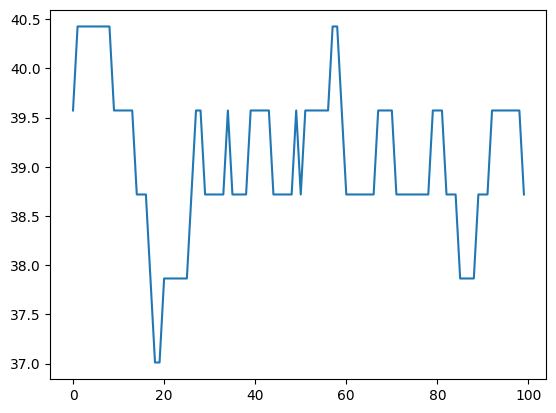

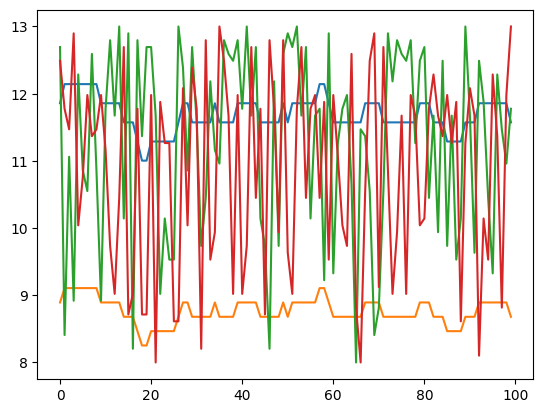

In [27]:
import matplotlib.pyplot as plt
k = 100
plt.plot(u_history[-k:])
plt.show()

plt.plot(qc_history[-k:])
plt.plot(qm_history[-k:])
plt.plot(q1_history[-k:])
plt.plot(q2_history[-k:])
plt.show()

### Correlations with shocks

In [28]:
k = 1000
np.corrcoef([u_history[-k:], q1_history[-k:], q2_history[-k:]])

array([[ 1.  , -0.07,  0.11],
       [-0.07,  1.  , -0.02],
       [ 0.11, -0.02,  1.  ]])

### Impulse Response

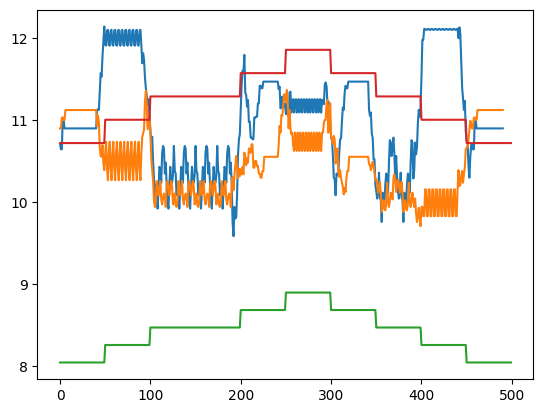

In [29]:
# initialize the state
state1 = int(num_states1/2)
state2 = int(num_states1/2)
u = 40
uidx = 0
temperature = 0.001
q1_impulse=[]
q2_impulse=[]
qm_impulse=[]
qc_impulse=[]

# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 500
for episode in range(num_episodes):

    if episode in [50]:
        uidx = 1
    elif episode in [100]:
        uidx = 2
    elif episode in [200]:
        uidx = 3
    elif episode in [250]:
        uidx = 4
    elif episode in [300]:
        uidx = 3    
    elif episode in [350]:
        uidx = 2 
    elif episode in [400]:
        uidx = 1 
    elif episode in [450]:
        uidx = 0       
    #if episode in [13]:
    #    action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
    #    action2 = 5
    #elif episode in [24]:
    ##    action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
     #   action2 = num_actions-5  
    else:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    #u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    q1_impulse.append(quantity1)
    q2_impulse.append(quantity2)
    qm_impulse.append(cournot(40 + Z[uidx],v,w,n).Qm/2)
    qc_impulse.append(cournot(40 + Z[uidx],v,w,n).Qc/2)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
import matplotlib.pyplot as plt
plt.plot(moving_average(q1_impulse,10))
plt.plot(moving_average(q2_impulse,10))
plt.plot(qm_impulse)
plt.plot(qc_impulse)
plt.show()

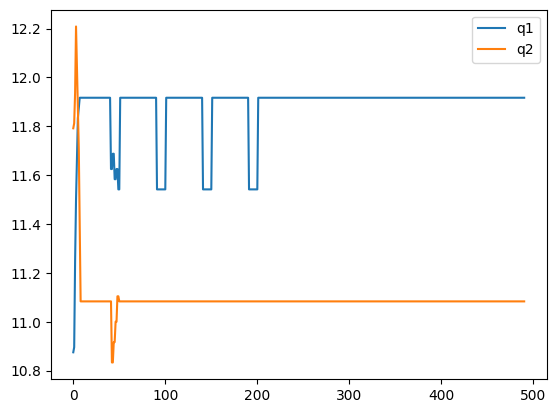

In [676]:
# initialize the state
state1 = int(num_states1/2)
state2 = int(num_states1/2)
u = 40
uidx = 0
temperature = 0.0001
q1_impulse=[]
q2_impulse=[]
qm_impulse=[]
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 500
for episode in range(num_episodes):
      
    if episode in [50]:
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)
        action1 = 0
    elif episode in [100]:
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)
        action1 = 0
    elif episode in [150]:
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)
        action1 = 0
    elif episode in [200]:
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)
        action1 = 0   
    else:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    #u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    q1_impulse.append(quantity1)
    q2_impulse.append(quantity2)
    qm_impulse.append(cournot(40 + Z[uidx],v,w,n).Qm/2)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
import matplotlib.pyplot as plt
plt.plot(moving_average(q1_impulse,10), label='q1')
plt.plot(moving_average(q2_impulse,10), label='q2')
plt.legend()
#plt.plot(qm_impulse)
plt.show()

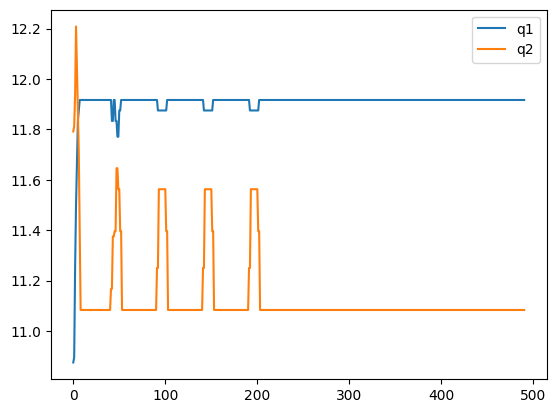

In [679]:
# initialize the state
state1 = int(num_states1/2)
state2 = int(num_states1/2)
u = 40
uidx = 0
temperature = 0.0001
q1_impulse=[]
q2_impulse=[]
qm_impulse=[]
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 500
for episode in range(num_episodes):
      
    if episode in [50]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 24
    elif episode in [100]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 24
    elif episode in [150]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 24
    elif episode in [200]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 24  
    else:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    #u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    q1_impulse.append(quantity1)
    q2_impulse.append(quantity2)
    qm_impulse.append(cournot(40 + Z[uidx],v,w,n).Qm/2)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
import matplotlib.pyplot as plt
plt.plot(moving_average(q1_impulse,10), label='q1')
plt.plot(moving_average(q2_impulse,10), label='q2')
plt.legend()
#plt.plot(qm_impulse)
plt.show()